In [1]:
import click
import numpy as np
import pandas as pd

from covid_model_seiir_pipeline.lib import (
    cli_tools,
)
from covid_model_seiir_pipeline.pipeline.forecasting import model
from covid_model_seiir_pipeline.side_analysis.oos_holdout.specification import (
    OOSHoldoutSpecification,
    OOS_HOLDOUT_JOBS,
)
from covid_model_seiir_pipeline.side_analysis.oos_holdout.data import (
    OOSHoldoutDataInterface,
)


logger = cli_tools.task_performance_logger


In [18]:
oos_holdout_version = '/ihme/covid-19-2/seir-oos-analysis/2022_04_01.11'
draw_id = 0
progress_bar = True

In [19]:
specification = OOSHoldoutSpecification.from_version_root(oos_holdout_version)
num_cores = specification.workflow.task_specifications[OOS_HOLDOUT_JOBS.oos_forecast].num_cores
data_interface = OOSHoldoutDataInterface.from_specification(specification)

scenario = specification.data.seir_forecast_scenario
forecast_specification = data_interface.forecast_data_interface.load_specification()
scenario_spec = forecast_specification.scenarios[scenario]

hierarchy = data_interface.load_hierarchy('pred')


#################
# Build indices #
#################
# The hardest thing to keep consistent is data alignment. We have about 100
# unique datasets in this model, and they need to be aligned consistently
# to do computation.
logger.info('Loading index building data', context='read')
location_ids = data_interface.load_location_ids()
holdout_days = pd.Timedelta(days=specification.parameters.holdout_weeks * 7)
past_compartments = data_interface.load_past_compartments(draw_id).loc[location_ids]
past_compartments = past_compartments.loc[past_compartments.notnull().any(axis=1)]
past_start_dates = past_compartments.reset_index(level='date').date.groupby('location_id').min()
beta_fit_end_dates = past_compartments.reset_index(level='date').date.groupby('location_id').max()
beta_fit_oos_end_dates = beta_fit_end_dates - holdout_days

# We want the forecast to start at the last date for which all reported measures
# with at least one report in the location are present.
all_measures_present = past_compartments[
    [c for c in past_compartments if c.split('_')[0] in ['Death', 'Admission', 'Case']]
].notnull().all(axis=1)
forecast_start_dates = (past_compartments
                        .loc[all_measures_present]
                        .reset_index(level='date')
                        .date.groupby('location_id')
                        .max())
forecast_oos_start_dates = np.minimum(forecast_start_dates, beta_fit_oos_end_dates)



# Forecast is run to the end of the covariates
covariates = data_interface.load_covariates()
forecast_end_dates = covariates.reset_index().groupby('location_id').date.max()
population = data_interface.load_population('total').population

logger.info('Building indices', context='transform')
indices = model.Indices(
    past_start_dates,
    beta_fit_end_dates,
    forecast_start_dates,
    forecast_end_dates,
)
oos_indices = model.Indices(
    past_start_dates,
    beta_fit_oos_end_dates,
    forecast_oos_start_dates,
    forecast_end_dates,
)

2022-04-01 22:29:02.637 | INFO     | covid_model_seiir_pipeline.lib.cli_tools.performance_logger.performance_logger:info:26 - Loading index building data
2022-04-01 22:29:45.617 | INFO     | covid_model_seiir_pipeline.lib.cli_tools.performance_logger.performance_logger:info:26 - Building indices


In [20]:
ref = data_interface.load_raw_outputs(scenario, draw_id)
oos = data_interface.load_oos_outputs(draw_id)

In [21]:
params = data_interface.load_fit_ode_params(draw_id).filter(like='exposure').iloc[0]
delay = {
    'infections': 0,
    'deaths': params.loc['exposure_to_death'],
    'admissions': params.loc['exposure_to_admission'],
    'case': params.loc['exposure_to_case'],
    'beta': 0,
}

In [22]:
cols = {
    'modeled_infections_total': 'infections', 
    'modeled_deaths_total': 'deaths', 
    'modeled_admissions_total': 'admissions', 
    'modeled_cases_total': 'cases', 
    'beta': 'beta'
}
data = {
    'reference': ref,
    'oos': oos,
    'delta': ref - oos,
}
idx_cols = ['location_id', 'date', 'measure']
output = []
for key, df in data.items():
    df = df.loc[:, list(cols.keys())].rename(columns=cols)
    df = df.stack().reset_index()
    df.columns = ['location_id', 'date', 'measure', key]
    df = df.set_index(['location_id', 'date', 'measure'])[key].sort_index()
    output.append(df)
    
data = pd.concat(output, axis=1).unstack().reorder_levels([1, 0], axis=1).sort_index(axis=1)



In [23]:
location_id = 555
location_name = hierarchy.set_index('location_id').location_name.loc[location_id]
leading_days = pd.Timedelta(days=int(holdout_days.days / 3))
start = beta_fit_oos_end_dates.loc[location_id] - 10*leading_days
oos_start = beta_fit_oos_end_dates.loc[location_id]
end = forecast_start_dates.loc[location_id] + holdout_days


loc_data = data.loc[location_id]


In [24]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.lines as mlines
import numpy as np
import pandas as pd
import seaborn as sns

sns.set_style('whitegrid')


FILL_ALPHA = 0.2
OBSERVED_ALPHA = 0.3
AX_LABEL_FONTSIZE = 14
TITLE_FONTSIZE = 24
FIG_SIZE = (30, 15)
GRID_SPEC_MARGINS = {'top': 0.92, 'bottom': 0.08}


def make_axis_legend(axis, elements: dict):
    handles = [mlines.Line2D([], [], label=e_name, linewidth=2.5, **e_props)
               for e_name, e_props in elements.items()]
    axis.legend(handles=handles,
                loc='upper left',
                fontsize=AX_LABEL_FONTSIZE,
                frameon=False)
    
def format_date_axis(ax, start=None, end=None):
    date_locator = mdates.AutoDateLocator(maxticks=15)
    date_formatter = mdates.ConciseDateFormatter(date_locator, show_offset=False)
    ax.set_xlim(start, end)
    ax.xaxis.set_major_locator(date_locator)
    ax.xaxis.set_major_formatter(date_formatter)

Text(0.5, 0.98, 'New York (555)')

/share/code/collijk/miniconda/envs/seir-slurm/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


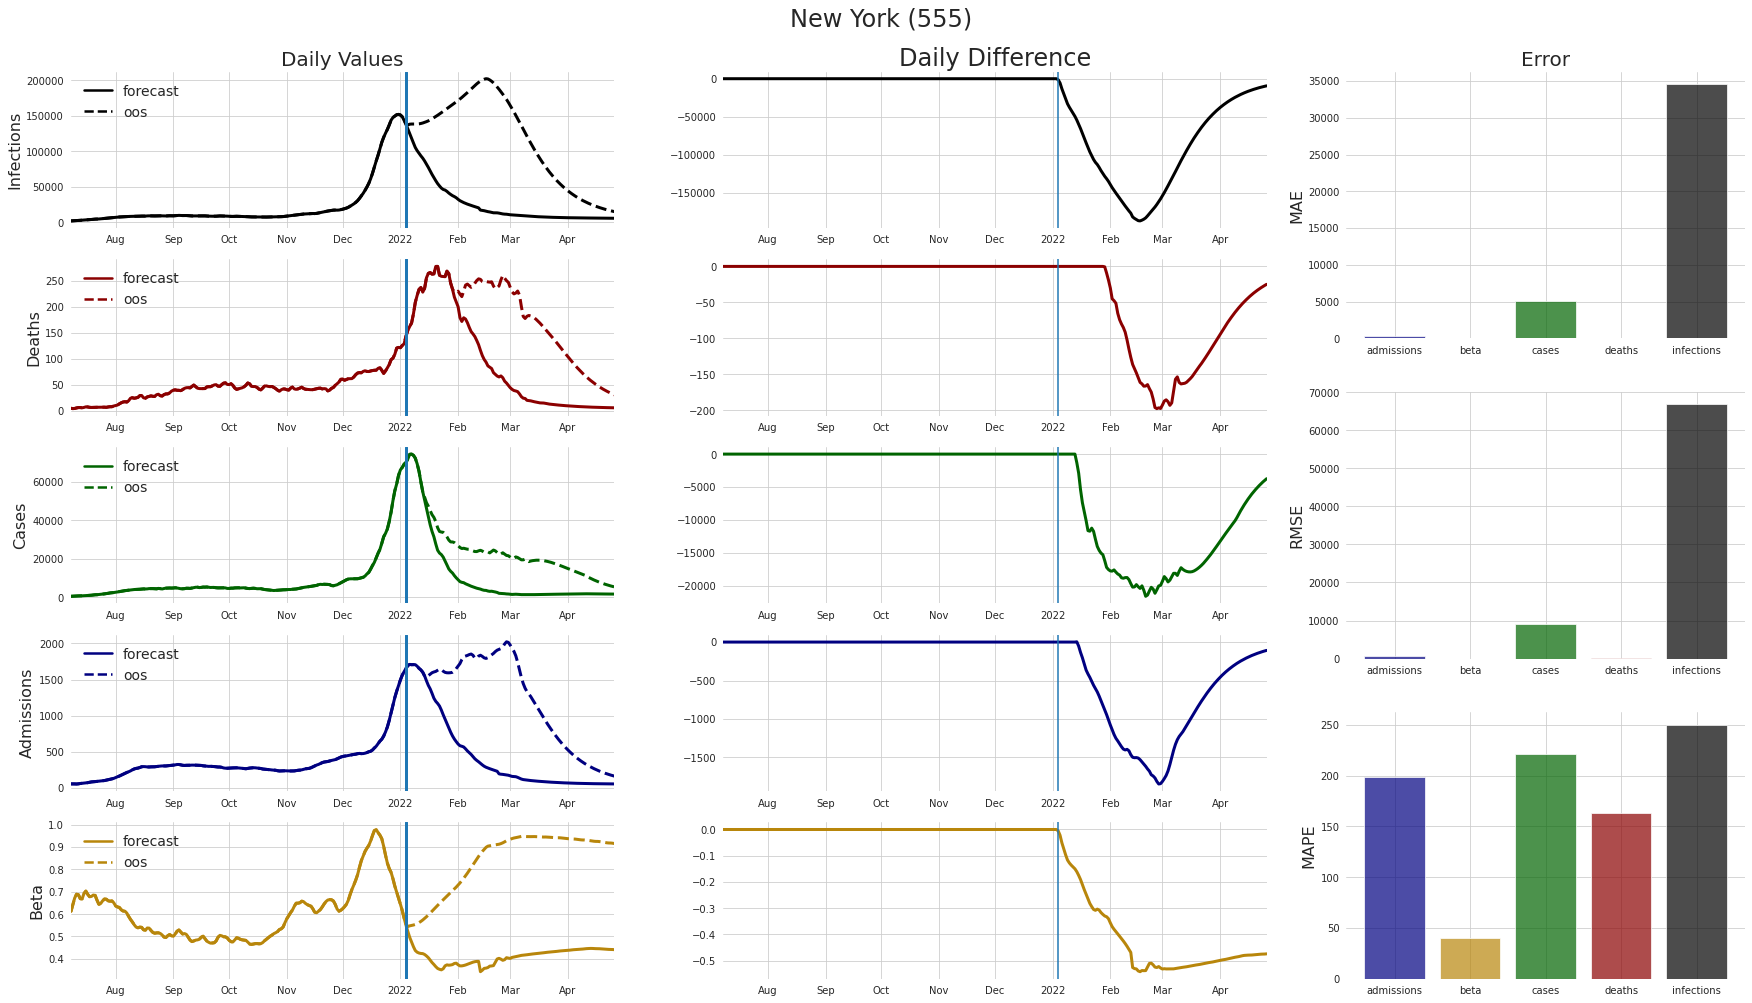

In [25]:
# Configure the plot layout.
fig = plt.figure(figsize=FIG_SIZE, tight_layout=True)
grid_spec = fig.add_gridspec(
    nrows=1, ncols=2,
    width_ratios=[6, 2],
    wspace=0.1,
)
grid_spec.update(**GRID_SPEC_MARGINS)

gs_line = grid_spec[0, 0].subgridspec(5, 2)
gs_hist = grid_spec[0, 1].subgridspec(3, 1)


cmap = {
    'infections': 'k',
    'deaths': 'darkred',
    'cases': 'darkgreen',
    'admissions': 'navy',
    'beta': 'darkgoldenrod',
}



for row, (measure, color) in enumerate(cmap.items()):
    df = loc_data.loc[start:end, measure]    
    for col, plot_type in enumerate(['abs', 'delta']):
        ax = fig.add_subplot(gs_line[row, col])
        if plot_type == 'abs':
            ax.plot(df.index, df.loc[:, 'reference'], linewidth=3, color=color)
            ax.plot(df.index, df.loc[:, 'oos'], linewidth=3, linestyle='dashed', color=color)
            ax.axvline(oos_start, linewidth=3)
            ax.set_ylabel(measure.title(), fontsize=16)
            make_axis_legend(ax, {'forecast': {'linestyle': 'solid', 'color': color},
                                  'oos': {'linestyle': 'dashed', 'color': color}})
            if row == 0:
                ax.set_title('Daily Values', fontsize=20)
        else:
            ax.plot(df.index, df.loc[:, 'delta'], linewidth=3, color=color)
            ax.axvline(oos_start)
            if row == 0:
                ax.set_title('Daily Difference', fontsize=24)
        format_date_axis(ax, start, end)

df = loc_data.loc[start:end].stack().reset_index().rename(columns={'level_1': 'version'})
delta = df[df.version == 'delta'].drop(columns='version').set_index('date')
y = df[df.version == 'reference'].drop(columns='version').set_index('date')
p = 100*delta / y

err = pd.concat([
    np.abs(delta).mean(axis=0).rename('MAE'),
    np.sqrt((delta**2).mean(axis=0)).rename('RMSE'),
    np.abs(p).mean(axis=0).rename('MAPE')
], axis=1)


for row, measure in enumerate(err.columns):
    ax = fig.add_subplot(gs_hist[row])
    ax.bar(err.index.values, err[measure].values, color=[cmap[m] for m in err.index], alpha=0.7)
    ax.set_ylabel(measure, fontsize=16)
    if row == 0:
        ax.set_title('Error', fontsize=20)    
        
sns.despine(fig=fig, left=True, bottom=True)
fig.suptitle(f'{location_name} ({location_id})',
             x=0.5,
             fontsize=24,
             ha='center')

    
                
               

